In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# The token can be used to access the repository
!git clone https://github.com/cariello1/BIO-NER-.git

Cloning into 'BIO-NER-'...
remote: Enumerating objects: 493, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 493 (delta 75), reused 0 (delta 0), pack-reused 365
Receiving objects: 100% (493/493), 12.49 MiB | 23.59 MiB/s, done.
Resolving deltas: 100% (261/261), done.


In [ ]:
%cd /content/BIO-NER-

/content/BIO-NER-


In [ ]:
%%capture
!pip install tensorflow==2.3

In [ ]:
%%capture
import tensorflow as tf

In [ ]:
# Check version
tf.__version__

'2.3.0'

In [ ]:
%%capture
# CRF layer for tensorflow 2 supportig keras masking
!pip install tf2crf

In [ ]:
from preprocessing_1 import PreprocessingDocsNN
from preprocessing_1 import read_data

# PREPROCESSING

In [ ]:
import numpy as np
import codecs
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow

In [ ]:
# For reproducibility
seed = 768
tf.random.set_seed(seed)

In [ ]:
# Original data in IOB format
file1_train = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/train.tsv"
file2_test = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/test.tsv"
file3_dev = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/devel.tsv"

In [ ]:
input_train = read_data(file1_train)
input_test = read_data(file2_test)
input_dev = read_data(file3_dev)

Total number of sentences: 30682 
Total number of sentences: 26364 
Total number of sentences: 30639 


In [ ]:
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)
docs_dev = PreprocessingDocsNN(input_dev)

In [ ]:
# First sentence of dataset with both words and labels
print('This is what a sentence looks like:{}'.format(input_train[0]))

This is what a sentence looks like:[('DPP6', 'O'), ('as', 'O'), ('a', 'O'), ('candidate', 'O'), ('gene', 'O'), ('for', 'O'), ('neuroleptic', 'O'), ('-', 'O'), ('induced', 'O'), ('tardive', 'O'), ('dyskinesia', 'O'), ('.', 'O')]


In [ ]:
print("\033[1m"+"Statistics for the train set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))

Statistics for the train set:
Number of sentences: 30682
Number of tokens: 891948
Size of vocabulary: 40528
Tagset: B-Chemical I-Chemical O
Number of Tags 3


# DATA VISUALIZATION

In [ ]:
sentences_len = np.array([len(s) for s in docs_train.sentences]) #list with len for each sents

In [ ]:
#max_seq_len = np.round(sentences_len.mean()+sentences_len.std()).astype(int) #timesteps

In [ ]:
sen_mean = np.round(sentences_len.mean()).astype(int) 

In [ ]:
max_seq_len = 50 #timesteps

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


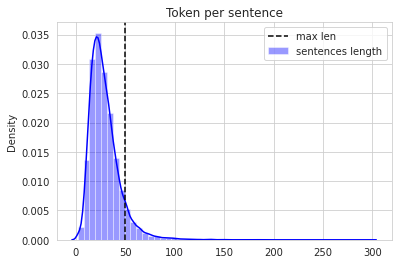

In [ ]:
sns.distplot(sentences_len, hist=True, kde=True, color="b", label="sentences length")
plt.axvline(x=max_seq_len, color="k", linestyle="--", label="max len")
plt.title("Token per sentence")
plt.legend()
plt.show()

In [ ]:
sent_less_than_msl = [s for s in docs_train.sentences if len(s) <= 50]
perc_sent = round(len(sent_less_than_msl) / len(docs_train.sentences) * 100)
print("The", perc_sent,"%", "of sentences has less or equal than 50 tokens.")

The 92 % of sentences has less or equal than 50 tokens.


# GLOVE PRE-TRAINED WORD VECTORS

In [ ]:
%%time
# Unzipping of GloVe

import requests, zipfile, io
zip_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()



In [ ]:
print("Loading word embeddings...")

embedding_index = {}       
f = codecs.open("glove.840B.300d.txt", encoding = "utf-8")

for line in tqdm(f):
  values = line.rstrip().rsplit(" ")
  word = values[0]
  coefs = np.asarray(values[1:], dtype ="float32")
  embedding_index[word]=coefs

f.close()  #vettori 300d per word

print("found %s word vectors" % len(embedding_index))

In [ ]:
len(embedding_index.get("cell")) #300 d-array

# PREPROCESSING FOR TRAINING

Before feeding the data to the model we need to further preprocess the text. In order to feed the data to the Bi-LSTM model, we need to ensure that all text should be of the same length. The method sequence pad_sequences() and variable max_seq_len are used for this purpose. The text which are shorter than fixed max_seq_len value are padded to get them to the same length, whereas text which are longer than max_seq_len are truncated. Then, we use the TextVectorization layer from tf as text encoder. This allows to transforms a sequences of strings into a list of token indices. Every token in a sequence is mapped to a corresponding integer ID. This saves a lot of memory.

In [ ]:
# Padding sentences to the max_seq_len
from keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(maxlen=max_seq_len, sequences=docs_train.sentences, padding="post", value="", dtype=object, truncating = "post")
X_test_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_test.sentences, padding="post", value="", dtype=object, truncating = "post")
X_dev_padded = pad_sequences(maxlen=max_seq_len, sequences=docs_dev.sentences, padding="post", value="", dtype=object, truncating = "post")

In [ ]:
X_test_padded[812]

In [ ]:
X_dev_padded[812]

In [ ]:
# Vocabulary Key:Tag -> Value:ID_tag & Vocabulary Key:ID_tag -> Value:Tag
tag2idx, idx2tag = docs_train.from_labels_2_idx()

In [ ]:
# Padding and encoding the target variable
y_train = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)
y_dev = docs_dev.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
# Decoding one-hot vectors
y_train = np.argmax(y_train, axis = -1)
y_test = np.argmax(y_test, axis = -1)
y_dev = np.argmax(y_dev, axis = -1)

In [ ]:
# Build the text encoder layer
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(split=None, standardize = None, ngrams=None,max_tokens=None, output_mode = "int")

In [ ]:
# Create the vocabulary
encoder.adapt(docs_train.tokens)

In [ ]:
# Extract the vocabulary
voc = np.array(encoder.get_vocabulary())

In [ ]:
# Explore first 30 more frequent words in the train set, first entry reserved for PAD
voc[:30] 

In [ ]:
# A dict mapping words to their IDs
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# A dict mapping IDs to their words
idx2word = {i: w for w, i in word_index.items()}

In [ ]:
# Map padded sentences to integer IDs
X_train = encoder(np.array(X_train_padded))
X_test = encoder(np.array(X_test_padded))
X_dev = encoder(np.array(X_dev_padded))

In [ ]:
# Decoding in the test set; some words that are OOV are decoded as [UNK]
for n in range(3):
  print("Original: ", docs_test.sentences[n])
  print("Round-trip: ", " ".join(voc[X_test[n]]))
  print() 

In [ ]:
print("The word 'cell' is identified by the index: {}".format(word_index["cell"]))
print("The labels 'B-Chemical' is identified by the index: {}".format(tag2idx["B-Chemical"]))

# EMBEDDING MATRIX

Building the embedding matrix for the weights in the Embedding Layer. All words that aren't in the pre-trained model from fastTest would be changed to 0. 

In [ ]:
# Vocabulary size
voc_size = len(word_index)

In [ ]:
# Embedding matrix

print("preparing embedding matrix...")

num_tokens = len(voc)
embedding_dim = 300
hits = 0
misses = 0
words_not_found = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        words_not_found.append(word)
print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
print("sample words not found: {}".format(np.random.choice(words_not_found, 30)))

# CHAR EMBEDDING

In [ ]:
max_len_char = 10

In [ ]:
len(voc)

In [ ]:
chars = set([w_i for w in voc for w_i in w]) #characters dictionary
n_chars = len(chars)
print(n_chars)

In [ ]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx[""] = 0

In [ ]:
char2idx["-"]

In [ ]:
X_train[0]

In [ ]:
X_dev[0]

In [ ]:
X_char_train = []
for s in X_train_padded.tolist():
    sent_seq = []
    for i in range(max_seq_len):
        word_seq = []
        for j in range(max_len_char):
          try:
            word_seq.append(char2idx.get(s[i][j]))
          except:
            word_seq.append(char2idx.get(""))
        sent_seq.append(word_seq)
    X_char_train.append(np.array(sent_seq))

In [ ]:
X_char_train[0].shape

In [ ]:
X_char_dev = []
for s in X_dev_padded:
    sent_seq = []
    for i in range(max_seq_len):
        word_seq = []
        for j in range(max_len_char):
          try:
            word_seq.append(char2idx.get(s[i][j]))
          except:
            word_seq.append(char2idx.get(""))
        sent_seq.append(word_seq)
    X_char_dev.append(np.array(sent_seq))

In [ ]:
X_char_test = []
for s in X_test_padded.tolist():
    sent_seq = []
    for i in range(max_seq_len):
        word_seq = []
        for j in range(max_len_char):
          try:
            word_seq.append(char2idx.get(s[i][j]))
          except:
            word_seq.append(char2idx.get(""))
        sent_seq.append(word_seq)
    X_char_test.append(np.array(sent_seq))

In [ ]:
print("First word in the first sentence: {}".format(X_train_padded[0][0]))
print("Mapped: {}".format(X_char_train[0][0]))

In [ ]:
BATCH_SIZE = 32

In [ ]:
len(X_dev)

In [ ]:
"""X_train = X_train[:958 * BATCH_SIZE]
X_char_train = X_char_train[:958 * BATCH_SIZE]
y_train = y_train[:958 * BATCH_SIZE]"""

In [ ]:
"""X_dev = X_dev[:957 * BATCH_SIZE]
X_char_dev = X_char_dev[:957 * BATCH_SIZE]
y_dev = y_dev[:957 * BATCH_SIZE]"""

In [ ]:
print("Size of training set ", len(X_train))
print("Size of validation set ", len(X_dev))

# IMPLEMENTING MODEL ARCHITECTURE

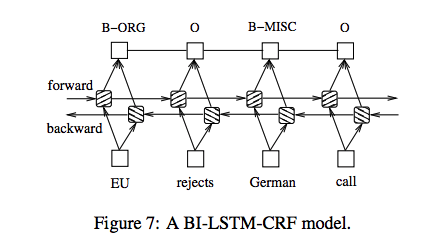


Model Architecture 

In [ ]:
# Hyperparams initialization
EPOCHS = 10
EMBEDDING = 300

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, concatenate, SpatialDropout1D
from tf2crf import CRF, ModelWithCRFLoss
#from keras.layers import Masking

In [ ]:
len(voc)

In [ ]:
# Defining the embedding layer
embedding_layer = Embedding(
    len(voc),
    EMBEDDING,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero = True
)

In [ ]:
embedding_matrix.shape[0]

In [ ]:
#Model definition

# input and embeddings for words
word_in = Input(shape=(max_seq_len,), dtype="int32")
emb_word = embedding_layer(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_seq_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char))(char_in)

# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
model = Bidirectional(LSTM(units=256, return_sequences=True,
                    recurrent_dropout=0.2))(x)
model = Bidirectional(LSTM(units=125, return_sequences=True,
                    recurrent_dropout=0.2))(model)

out = (Dense(len(tag2idx), activation=None))(model)
crf = CRF(dtype='float32') # CRF layer
output = crf(out)
base_model = Model([word_in, char_in], output)
model = ModelWithCRFLoss(base_model)
model.compile(optimizer=RMSprop())

In [ ]:
 print(base_model.summary())

In [ ]:
"""#try different optimizers

for OPTIMAZER in [SGD(), Adam(), RMSprop()]:
  print()
  model.compile(optimizer=OPTIMAZER, loss= crf_losses.crf_loss, metrics=[crf_accuracies.crf_viterbi_accuracy])
  model.fit(X_train, np.array(y_train), epochs=5, batch_size=32, verbose=1, validation_data=(X_val, np.array(y_val)))
  score = model.evaluate(X_test, np.array(y_test))
  print()
  print("OPTIMEZER: ", OPTIMAZER)
  print("\nTest score ", score[0])
  print("Test accuracy: ", score[1])"""

# TRAINING

In [ ]:
dir_output = "/content/drive/MyDrive/BIO-NER-project/GloVeChar-bi-lstm-crf-BC4CHEMD.h5"

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_crf_loss_val", patience=2)

In [ ]:
def ignoring_padding(y_pred,y_test):
  """This function allows to compare predicted labels with true labels discarding padding"""
  real_pred = []
  y_test_nozeroes = [[l for l in s if l != 0] for s in y_test] # Delete padding label in the original sentences
  for s, s1 in zip(y_pred, y_test_nozeroes):
    s = s.tolist() 
    real_s =  s[:len(s1)] # Delete padding from the predicted sentences
    real_pred.append(real_s)
  pred_tag = [[idx2tag[i] for i in row] for row in real_pred]
  y_test_tag = [[idx2tag[i] for i in row] for row in y_test_nozeroes]
  return pred_tag, y_test_tag

In [ ]:
%%capture
!pip3 install seqeval

In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score

class Metrics(Callback):
    """Custom F1 metric to look after the performance on the validation set during the training"""
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0][0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
     
    def on_epoch_begin(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = self.model.predict(self.validation[0])[0]
        y_true, y_hat = ignoring_padding(val_predict, val_targ)
        val_f1 = f1_score(y_true, y_hat)
        
        
        self.val_f1s.append(round(val_f1, 6))
        
 
        print(f' — val_f1: {val_f1} ')

In [ ]:
X_char_dev = np.asarray(X_char_dev).astype(np.float32)

In [ ]:
# Customised callbacks
mycallbacks = [Metrics(validation=([X_dev,
                     X_char_dev.reshape((len(X_char_dev), max_seq_len, max_len_char))], y_dev)), early_stopping]

In [ ]:
%%time
# Fit network - F1-score is measured on the validation data
history = model.fit([X_train,
                     np.array(X_char_train).reshape((len(X_char_train), max_seq_len, max_len_char))],y_train, epochs=EPOCHS,batch_size=BATCH_SIZE, verbose=1, validation_data=([X_dev,
                    X_char_dev.reshape((len(X_char_dev), max_seq_len, max_len_char))], y_dev), callbacks= mycallbacks)

In [ ]:
#model.summary()

In [ ]:
model.save_weights(dir_output)

Output = viterbi_sequence, inputs(the output of the previous layer), sequence_lengths (mask), self.transitions (crf transmission parameters)

# LEARNING CURVES

In [ ]:
epochs = len(history.epoch)

In [ ]:
loss_train = [2.3600, 0.9675, 0.6642, 0.5041, 0.4091]
loss_val = history.history['val_crf_loss_val']
epochs = range(0,epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_val_accuracy']
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# PREDICTION AND EVALUATION

In [ ]:
#model = build_model(max_seq_len, RMSprop())

In [ ]:
dir_output

In [ ]:
#model.variables

In [ ]:
# This saves me
model.built = True 

In [ ]:
model.load_weights(dir_output)

In [ ]:
#X_test = X_test[:120*BATCH_SIZE]
#X_char_test = X_char_test[:120*BATCH_SIZE]
#y_test = y_test[:120*BATCH_SIZE]

In [ ]:
X_char_test = np.asarray(X_char_test).astype(np.float32)

In [ ]:
%%time
y_pred = model.predict([X_test,
                     np.array(X_char_test).reshape((len(X_char_test), max_seq_len, max_len_char))])[0]

In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

# REPORT

In [ ]:
from seqeval.metrics import classification_report

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

In [ ]:
from seqeval.scheme import IOB2
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

# COMPARE RESULTS

In [ ]:
i = 18  #prendi il chunck di frasi da 390 a 390+32
p = model.predict([X_test[i:i+BATCH_SIZE], np.array(X_char_test).reshape((len(X_char_test), max_seq_len, max_len_char))[i:i+BATCH_SIZE]])[0][0]
#p = np.argmax(p, axis=-1)

In [ ]:
# From tensor to array
X_true1 = tf.make_tensor_proto(X_test)
X_true1 = tf.make_ndarray(X_true1)

In [ ]:
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*45)
for w, true, pred in zip(X_true1[i], y_true[i], p):
    if w != 0:
      print("{:15}:{:15} ({})".format(idx2word[w], idx2tag[pred], true))

# EXPLORING EMBEDDING LAYER

In [ ]:
# Embeddings has a shape of (vocab_size, embedding_dim)
embeddings = model.layers[0].get_weights()[1] #embeddings

In [ ]:
# Explore dictionary
word_index.items()

In [ ]:
embeddings.shape

In [ ]:
# Word2idx is a mapping (i.e. dict) from words to their index, e.g. "cell": 69
words_embeddings = {w:embeddings[idx] for w, idx in word_index.items()}

In [ ]:
print("What is the vector representation for the word 'cell'?")
words_embeddings["cell"][:20] #first 20 dim

# TUNING LEARNING RATE

LRFinder implements a Keras Callback which tracks the loss associated with a learning rate varied linearly over a defined range. Implementation by https://github.com/WittmannF

In [ ]:
#from keras.callbacks import Callback

In [ ]:
"""from keras.callbacks import Callback
import keras.backend as K
import matplotlib.pyplot as plt

class LRFinder(Callback):
    
    Up-to date version: https://github.com/WittmannF/LRFinder
    Example of usage:
        from keras.models import Sequential
        from keras.layers import Flatten, Dense
        from keras.datasets import fashion_mnist
        !git clone https://github.com/WittmannF/LRFinder.git
        from LRFinder.keras_callback import LRFinder
        # 1. Input Data
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        mean, std = X_train.mean(), X_train.std()
        X_train, X_test = (X_train-mean)/std, (X_test-mean)/std
        # 2. Define and Compile Model
        model = Sequential([Flatten(),
                            Dense(512, activation='relu'),
                            Dense(10, activation='softmax')])
        model.compile(loss='sparse_categorical_crossentropy', \
                      metrics=['accuracy'], optimizer='sgd')
        # 3. Fit using Callback
        lr_finder = LRFinder(min_lr=1e-4, max_lr=1)
        model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder], epochs=2)
    
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('crf_loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()"""

In [ ]:
"""# input and embedding for words

def build_model(opt=None):
  word_in = Input(shape=(max_seq_len,), dtype="int32")
  emb_word = embedding_layer(word_in)

# input and embeddings for characters
  char_in = Input(shape=(max_seq_len, max_len_char,))
  emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10, input_length=max_len_char))(char_in)

# character LSTM to get word encodings by characters
  char_enc = TimeDistributed(LSTM(units=20, return_sequences=False, recurrent_dropout=0.5))(emb_char)

# main LSTM
  x = concatenate([emb_word, char_enc])
  x = SpatialDropout1D(0.3)(x)
  model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.2))(x)
  model = Bidirectional(LSTM(units=125, return_sequences=True, recurrent_dropout=0.2))(model)

  out = (Dense(len(tag2idx), activation=None))(model)
  crf = CRF(dtype='float32') # CRF layer, n_tags+1(PAD) 
  output = crf(out)
  base_model = Model([word_in, char_in], output)
  model = ModelWithCRFLoss(base_model)

  if opt:
    opt = opt
  else:
    opt = Adam()

  model.compile(optimizer=opt)

  return model"""

In [ ]:
# Get an instance of LRTest class
#lr_finder = LRFinder(min_lr=1e-4, max_lr=1)


# Build the model again
#model2 = build_model(RMSprop())

In [ ]:
# Perform the LR range test 
#history = model2.fit([X_train,
 #                    np.array(X_char_train).reshape((len(X_char_train), max_seq_len, max_len_char))],y_train, epochs=10, batch_size=BATCH_SIZE, verbose=1, callbacks=[lr_finder])

# TRAIN THE MODEL WITH OPTIMAL LR

In [ ]:
# Build the model with the optimal lr
#model3 = build_model(RMSprop(lr=10**-2.3))

# Train the model
#model3.fit([X_train, np.array(X_char_train).reshape((len(X_char_train), max_seq_len, max_len_char))], y_train, epochs=7, batch_size=BATCH_SIZE, verbose=1, validation_data=([X_val,
 #                    np.array(X_char_val).reshape((len(X_char_val), max_seq_len, max_len_char))], y_val), callbacks=mycallbacks)

In [ ]:
%%time
y_pred = model.predict([X_test,
                     np.array(X_char_test).reshape((len(X_char_test), max_seq_len, max_len_char))])[0]

In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

# REPORT2

In [ ]:
print('\033[1m' + "Classification report for #2 model with LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

In [ ]:
import sys

print('Saving classification report on file...')

original_stdout = sys.stdout 

with open('/content/drive/MyDrive/output.txt', 'a') as f:
  sys.stdout = f # Change the standard output to the file we created.
  print('\033[1m' + "Classification report GloVe+CharEmb+Bi-LSTM+CRF for BC4CHEMD dataset: ")
  print('\033[0m')
  print(classification_report(y_true, y_hat))
  sys.stdout = original_stdout # Reset the standard output to its original value
print("Done.")